In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns
import os
import scipy
import scipy.io

In [2]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [3]:
a = scipy.io.loadmat("../data/zeisel/zeisel_data.mat")
data= a['zeisel_data'].T
N,d=data.shape

#load labels (first level of the hierarchy) from file
a = scipy.io.loadmat("../data/zeisel/zeisel_labels1.mat")
l_aux = a['zeisel_labels1']
l_0=[l_aux[i][0] for i in range(l_aux.shape[0])]
#load labels (second level of the hierarchy) from file
a = scipy.io.loadmat("../data/zeisel/zeisel_labels2.mat")
l_aux = a['zeisel_labels2']
l_1=[l_aux[i][0] for i in range(l_aux.shape[0])]
#construct an array with hierarchy labels
labels=np.array([l_0, l_1])

# load names from file 
a = scipy.io.loadmat("../data/zeisel/zeisel_names.mat")
names0=np.array([a['zeisel_names'][i][0][0] for i in range(N)])
names1=[a['zeisel_names'][i][1][0] for i in range(N)]

np.random.seed(100)
slices = np.random.permutation(np.arange(data.shape[0]))
upto = int(.8 * len(data))

train_data = data[slices[:upto]]
test_data = data[slices[upto:]]

train_labels = names0[slices[:upto]]
test_labels = names0[slices[upto:]]


scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_data = Tensor(train_data).to(device)
test_data = Tensor(test_data).to(device)

In [4]:
N = 10000
z_size = 100

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

global_t = 4
k = 50

In [5]:
def train_model(train_data, model):
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=lr, 
                                 betas = (b1,b2))
        
    for epoch in range(1, n_epochs+1):
        train(train_data, 
              model, 
              optimizer, 
              epoch, 
              batch_size)
        model.t = max(0.001, model.t * 0.99)

        
    return model

def save_model(base_path, model):
    # make directory
    if not os.path.exists(os.path.dirname(base_path)):
        try:
            os.makedirs(os.path.dirname(base_path))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise Exception("COULD NOT MAKE PATH")
    with open(base_path, 'wb') as PATH:
        torch.save(model.state_dict(), PATH)

In [203]:
def top_logits_gumbel_globalgate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_GlobalGate)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = data.shape[1]).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

def top_logits_gumbel_runningstate_vae(data, model):
    assert isinstance(model, VAE_Gumbel_RunningState)
    with torch.no_grad():
        w = model.logit_enc.clone().view(-1)
        top_k_logits = torch.topk(w, k = model.k, sorted = True)[1]
        enc_top_logits = torch.nn.functional.one_hot(top_k_logits, num_classes = data.shape[1]).sum(dim = 0)
        
        #subsets = sample_subset(w, model.k,model.t,True)
        subsets = sample_subset(w, model.k,model.t)
        #max_idx = torch.argmax(subsets, 1, keepdim=True)
        #one_hot = Tensor(subsets.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        
    return enc_top_logits, subsets

def top_logits_gumbel_concrete_vae_nsml(data, model):
    assert isinstance(model, ConcreteVAE_NMSL)
    
    with torch.no_grad():

        w = gumbel_keys(model.logit_enc, EPSILON = torch.finfo(torch.float32).eps)
        w = torch.softmax(w/model.t, dim = -1)
        subset_indices = w.clone().detach()

        #max_idx = torch.argmax(subset_indices, 1, keepdim=True)
        #one_hot = Tensor(subset_indices.shape)
        #one_hot.zero_()
        #one_hot.scatter_(1, max_idx, 1)

        all_subsets = subset_indices.sum(dim = 0)

        inds = torch.argsort(subset_indices.sum(dim = 0), descending = True)[:model.k]
        all_logits = torch.nn.functional.one_hot(inds, num_classes = data.shape[1]).sum(dim = 0)
        
        
        
        
    return all_logits, all_subsets

In [7]:
model = VAE_Gumbel_RunningState(train_data.shape[1], 200, 50, k = k, t = global_t, alpha = 0.9)
model.to(device)
train_model(train_data, model)
model.set_burned_in()

Train Epoch: 1 [0/2404 (0%)]	Loss: 2803.902344
Train Epoch: 1 [1280/2404 (53%)]	Loss: 2715.500488
====> Epoch: 1 Average loss: 2721.7661
Train Epoch: 2 [0/2404 (0%)]	Loss: 2628.183350
Train Epoch: 2 [1280/2404 (53%)]	Loss: 2573.851807
====> Epoch: 2 Average loss: 2566.7553
Train Epoch: 3 [0/2404 (0%)]	Loss: 2495.121094
Train Epoch: 3 [1280/2404 (53%)]	Loss: 2349.513184
====> Epoch: 3 Average loss: 2409.0056
Train Epoch: 4 [0/2404 (0%)]	Loss: 2295.737061
Train Epoch: 4 [1280/2404 (53%)]	Loss: 2281.776367
====> Epoch: 4 Average loss: 2252.8903
Train Epoch: 5 [0/2404 (0%)]	Loss: 2293.171631
Train Epoch: 5 [1280/2404 (53%)]	Loss: 2213.053711
====> Epoch: 5 Average loss: 2184.7032
Train Epoch: 6 [0/2404 (0%)]	Loss: 2090.993652
Train Epoch: 6 [1280/2404 (53%)]	Loss: 2073.529541
====> Epoch: 6 Average loss: 2165.9930
Train Epoch: 7 [0/2404 (0%)]	Loss: 2085.278320
Train Epoch: 7 [1280/2404 (53%)]	Loss: 2205.767578
====> Epoch: 7 Average loss: 2151.4521
Train Epoch: 8 [0/2404 (0%)]	Loss: 2183.9

====> Epoch: 59 Average loss: 2033.3220
Train Epoch: 60 [0/2404 (0%)]	Loss: 2100.468750
Train Epoch: 60 [1280/2404 (53%)]	Loss: 1984.810181
====> Epoch: 60 Average loss: 2032.4506
Train Epoch: 61 [0/2404 (0%)]	Loss: 2130.182129
Train Epoch: 61 [1280/2404 (53%)]	Loss: 1969.001587
====> Epoch: 61 Average loss: 2031.9955
Train Epoch: 62 [0/2404 (0%)]	Loss: 2117.096436
Train Epoch: 62 [1280/2404 (53%)]	Loss: 1934.874146
====> Epoch: 62 Average loss: 2030.1798
Train Epoch: 63 [0/2404 (0%)]	Loss: 1870.084351
Train Epoch: 63 [1280/2404 (53%)]	Loss: 2039.201538
====> Epoch: 63 Average loss: 2031.1647
Train Epoch: 64 [0/2404 (0%)]	Loss: 1929.613403
Train Epoch: 64 [1280/2404 (53%)]	Loss: 1998.742432
====> Epoch: 64 Average loss: 2030.6332
Train Epoch: 65 [0/2404 (0%)]	Loss: 2074.230469
Train Epoch: 65 [1280/2404 (53%)]	Loss: 2088.691162
====> Epoch: 65 Average loss: 2031.6826
Train Epoch: 66 [0/2404 (0%)]	Loss: 2073.372803
Train Epoch: 66 [1280/2404 (53%)]	Loss: 2070.904785
====> Epoch: 66 Aver

Train Epoch: 118 [1280/2404 (53%)]	Loss: 2008.415039
====> Epoch: 118 Average loss: 2022.2059
Train Epoch: 119 [0/2404 (0%)]	Loss: 2016.658081
Train Epoch: 119 [1280/2404 (53%)]	Loss: 2014.677490
====> Epoch: 119 Average loss: 2021.4766
Train Epoch: 120 [0/2404 (0%)]	Loss: 1887.104004
Train Epoch: 120 [1280/2404 (53%)]	Loss: 2114.639648
====> Epoch: 120 Average loss: 2017.3755
Train Epoch: 121 [0/2404 (0%)]	Loss: 2050.458008
Train Epoch: 121 [1280/2404 (53%)]	Loss: 1982.810669
====> Epoch: 121 Average loss: 2037.1033
Train Epoch: 122 [0/2404 (0%)]	Loss: 2053.983887
Train Epoch: 122 [1280/2404 (53%)]	Loss: 2019.987549
====> Epoch: 122 Average loss: 2022.9199
Train Epoch: 123 [0/2404 (0%)]	Loss: 2009.573486
Train Epoch: 123 [1280/2404 (53%)]	Loss: 1937.081055
====> Epoch: 123 Average loss: 2017.7318
Train Epoch: 124 [0/2404 (0%)]	Loss: 1959.778076
Train Epoch: 124 [1280/2404 (53%)]	Loss: 2050.473877
====> Epoch: 124 Average loss: 2023.2236
Train Epoch: 125 [0/2404 (0%)]	Loss: 1884.024780

====> Epoch: 175 Average loss: 2021.5857
Train Epoch: 176 [0/2404 (0%)]	Loss: 2009.369019
Train Epoch: 176 [1280/2404 (53%)]	Loss: 1974.391479
====> Epoch: 176 Average loss: 2023.2145
Train Epoch: 177 [0/2404 (0%)]	Loss: 1918.925903
Train Epoch: 177 [1280/2404 (53%)]	Loss: 2011.672363
====> Epoch: 177 Average loss: 2021.9670
Train Epoch: 178 [0/2404 (0%)]	Loss: 2054.835205
Train Epoch: 178 [1280/2404 (53%)]	Loss: 2252.192871
====> Epoch: 178 Average loss: 2021.7707
Train Epoch: 179 [0/2404 (0%)]	Loss: 2016.194580
Train Epoch: 179 [1280/2404 (53%)]	Loss: 2057.762207
====> Epoch: 179 Average loss: 2020.0640
Train Epoch: 180 [0/2404 (0%)]	Loss: 2063.296875
Train Epoch: 180 [1280/2404 (53%)]	Loss: 1978.481079
====> Epoch: 180 Average loss: 2020.0664
Train Epoch: 181 [0/2404 (0%)]	Loss: 1942.730469
Train Epoch: 181 [1280/2404 (53%)]	Loss: 2163.396240
====> Epoch: 181 Average loss: 2022.0600
Train Epoch: 182 [0/2404 (0%)]	Loss: 2052.639648
Train Epoch: 182 [1280/2404 (53%)]	Loss: 1907.490845

Train Epoch: 233 [1280/2404 (53%)]	Loss: 2024.973999
====> Epoch: 233 Average loss: 2016.7619
Train Epoch: 234 [0/2404 (0%)]	Loss: 1929.623779
Train Epoch: 234 [1280/2404 (53%)]	Loss: 1959.898193
====> Epoch: 234 Average loss: 2010.8615
Train Epoch: 235 [0/2404 (0%)]	Loss: 1939.849854
Train Epoch: 235 [1280/2404 (53%)]	Loss: 1973.870361
====> Epoch: 235 Average loss: 2014.2726
Train Epoch: 236 [0/2404 (0%)]	Loss: 2026.760742
Train Epoch: 236 [1280/2404 (53%)]	Loss: 2014.571655
====> Epoch: 236 Average loss: 2010.2369
Train Epoch: 237 [0/2404 (0%)]	Loss: 1953.540771
Train Epoch: 237 [1280/2404 (53%)]	Loss: 2014.110229
====> Epoch: 237 Average loss: 2012.7388
Train Epoch: 238 [0/2404 (0%)]	Loss: 1965.524902
Train Epoch: 238 [1280/2404 (53%)]	Loss: 2020.168579
====> Epoch: 238 Average loss: 2025.7184
Train Epoch: 239 [0/2404 (0%)]	Loss: 2024.089478
Train Epoch: 239 [1280/2404 (53%)]	Loss: 2040.362915
====> Epoch: 239 Average loss: 2030.7143
Train Epoch: 240 [0/2404 (0%)]	Loss: 2056.661865

====> Epoch: 290 Average loss: 2028.5976
Train Epoch: 291 [0/2404 (0%)]	Loss: 1980.560669
Train Epoch: 291 [1280/2404 (53%)]	Loss: 2034.415894
====> Epoch: 291 Average loss: 2032.6732
Train Epoch: 292 [0/2404 (0%)]	Loss: 2043.021606
Train Epoch: 292 [1280/2404 (53%)]	Loss: 2040.887085
====> Epoch: 292 Average loss: 2022.2834
Train Epoch: 293 [0/2404 (0%)]	Loss: 2008.530273
Train Epoch: 293 [1280/2404 (53%)]	Loss: 1982.675659
====> Epoch: 293 Average loss: 2011.7737
Train Epoch: 294 [0/2404 (0%)]	Loss: 2058.054932
Train Epoch: 294 [1280/2404 (53%)]	Loss: 2086.659668
====> Epoch: 294 Average loss: 2019.2188
Train Epoch: 295 [0/2404 (0%)]	Loss: 2009.889648
Train Epoch: 295 [1280/2404 (53%)]	Loss: 1968.950439
====> Epoch: 295 Average loss: 2013.7810
Train Epoch: 296 [0/2404 (0%)]	Loss: 2101.859375
Train Epoch: 296 [1280/2404 (53%)]	Loss: 1944.675415
====> Epoch: 296 Average loss: 2013.6452
Train Epoch: 297 [0/2404 (0%)]	Loss: 1922.912964
Train Epoch: 297 [1280/2404 (53%)]	Loss: 1981.089966

Train Epoch: 348 [1280/2404 (53%)]	Loss: 1961.383667
====> Epoch: 348 Average loss: 1956.0248
Train Epoch: 349 [0/2404 (0%)]	Loss: 1944.342773
Train Epoch: 349 [1280/2404 (53%)]	Loss: 1838.260864
====> Epoch: 349 Average loss: 1950.1409
Train Epoch: 350 [0/2404 (0%)]	Loss: 1935.010010
Train Epoch: 350 [1280/2404 (53%)]	Loss: 1988.679321
====> Epoch: 350 Average loss: 1952.3844
Train Epoch: 351 [0/2404 (0%)]	Loss: 2028.823120
Train Epoch: 351 [1280/2404 (53%)]	Loss: 1965.219360
====> Epoch: 351 Average loss: 1954.3700
Train Epoch: 352 [0/2404 (0%)]	Loss: 1987.480469
Train Epoch: 352 [1280/2404 (53%)]	Loss: 1998.892578
====> Epoch: 352 Average loss: 1949.2322
Train Epoch: 353 [0/2404 (0%)]	Loss: 1914.495850
Train Epoch: 353 [1280/2404 (53%)]	Loss: 1941.413086
====> Epoch: 353 Average loss: 1954.1476
Train Epoch: 354 [0/2404 (0%)]	Loss: 1901.736694
Train Epoch: 354 [1280/2404 (53%)]	Loss: 1984.610840
====> Epoch: 354 Average loss: 1951.9888
Train Epoch: 355 [0/2404 (0%)]	Loss: 1823.489502

====> Epoch: 405 Average loss: 1935.7358
Train Epoch: 406 [0/2404 (0%)]	Loss: 1937.175049
Train Epoch: 406 [1280/2404 (53%)]	Loss: 2053.728516
====> Epoch: 406 Average loss: 1939.6854
Train Epoch: 407 [0/2404 (0%)]	Loss: 1854.422241
Train Epoch: 407 [1280/2404 (53%)]	Loss: 1948.230347
====> Epoch: 407 Average loss: 1937.2483
Train Epoch: 408 [0/2404 (0%)]	Loss: 1891.446777
Train Epoch: 408 [1280/2404 (53%)]	Loss: 1914.969482
====> Epoch: 408 Average loss: 1933.4128
Train Epoch: 409 [0/2404 (0%)]	Loss: 1975.464844
Train Epoch: 409 [1280/2404 (53%)]	Loss: 1929.139893
====> Epoch: 409 Average loss: 1935.6673
Train Epoch: 410 [0/2404 (0%)]	Loss: 1876.369751
Train Epoch: 410 [1280/2404 (53%)]	Loss: 1911.632080
====> Epoch: 410 Average loss: 1934.0516
Train Epoch: 411 [0/2404 (0%)]	Loss: 1772.724487
Train Epoch: 411 [1280/2404 (53%)]	Loss: 1969.458374
====> Epoch: 411 Average loss: 1936.5890
Train Epoch: 412 [0/2404 (0%)]	Loss: 1963.179199
Train Epoch: 412 [1280/2404 (53%)]	Loss: 1956.115845

Train Epoch: 463 [1280/2404 (53%)]	Loss: 1940.004028
====> Epoch: 463 Average loss: 1909.1403
Train Epoch: 464 [0/2404 (0%)]	Loss: 1857.434570
Train Epoch: 464 [1280/2404 (53%)]	Loss: 1931.922607
====> Epoch: 464 Average loss: 1906.5920
Train Epoch: 465 [0/2404 (0%)]	Loss: 1880.574341
Train Epoch: 465 [1280/2404 (53%)]	Loss: 1899.497681
====> Epoch: 465 Average loss: 1909.9608
Train Epoch: 466 [0/2404 (0%)]	Loss: 1915.812500
Train Epoch: 466 [1280/2404 (53%)]	Loss: 1782.111938
====> Epoch: 466 Average loss: 1909.9213
Train Epoch: 467 [0/2404 (0%)]	Loss: 1836.937256
Train Epoch: 467 [1280/2404 (53%)]	Loss: 1864.963623
====> Epoch: 467 Average loss: 1909.7294
Train Epoch: 468 [0/2404 (0%)]	Loss: 1965.126831
Train Epoch: 468 [1280/2404 (53%)]	Loss: 1884.741089
====> Epoch: 468 Average loss: 1915.0881
Train Epoch: 469 [0/2404 (0%)]	Loss: 1981.320557
Train Epoch: 469 [1280/2404 (53%)]	Loss: 1887.207275
====> Epoch: 469 Average loss: 1911.7371
Train Epoch: 470 [0/2404 (0%)]	Loss: 1997.364746

====> Epoch: 520 Average loss: 1903.0533
Train Epoch: 521 [0/2404 (0%)]	Loss: 1861.582031
Train Epoch: 521 [1280/2404 (53%)]	Loss: 1951.983032
====> Epoch: 521 Average loss: 1896.8258
Train Epoch: 522 [0/2404 (0%)]	Loss: 1930.209595
Train Epoch: 522 [1280/2404 (53%)]	Loss: 1911.144653
====> Epoch: 522 Average loss: 1898.0758
Train Epoch: 523 [0/2404 (0%)]	Loss: 1879.457764
Train Epoch: 523 [1280/2404 (53%)]	Loss: 1898.093262
====> Epoch: 523 Average loss: 1899.5595
Train Epoch: 524 [0/2404 (0%)]	Loss: 1997.442261
Train Epoch: 524 [1280/2404 (53%)]	Loss: 1893.618652
====> Epoch: 524 Average loss: 1897.4894
Train Epoch: 525 [0/2404 (0%)]	Loss: 1982.535034
Train Epoch: 525 [1280/2404 (53%)]	Loss: 1855.449829
====> Epoch: 525 Average loss: 1902.2205
Train Epoch: 526 [0/2404 (0%)]	Loss: 1951.654663
Train Epoch: 526 [1280/2404 (53%)]	Loss: 1823.448608
====> Epoch: 526 Average loss: 1906.0590
Train Epoch: 527 [0/2404 (0%)]	Loss: 1949.032593
Train Epoch: 527 [1280/2404 (53%)]	Loss: 1976.385864

Train Epoch: 578 [1280/2404 (53%)]	Loss: 1868.958496
====> Epoch: 578 Average loss: 1891.0643
Train Epoch: 579 [0/2404 (0%)]	Loss: 1876.021362
Train Epoch: 579 [1280/2404 (53%)]	Loss: 1971.309204
====> Epoch: 579 Average loss: 1886.8015
Train Epoch: 580 [0/2404 (0%)]	Loss: 1795.043701
Train Epoch: 580 [1280/2404 (53%)]	Loss: 1805.491577
====> Epoch: 580 Average loss: 1888.7247
Train Epoch: 581 [0/2404 (0%)]	Loss: 1693.427856
Train Epoch: 581 [1280/2404 (53%)]	Loss: 1876.991577
====> Epoch: 581 Average loss: 1886.2884
Train Epoch: 582 [0/2404 (0%)]	Loss: 1968.852051
Train Epoch: 582 [1280/2404 (53%)]	Loss: 1790.959473
====> Epoch: 582 Average loss: 1888.0290
Train Epoch: 583 [0/2404 (0%)]	Loss: 1855.124634
Train Epoch: 583 [1280/2404 (53%)]	Loss: 1851.110229
====> Epoch: 583 Average loss: 1886.0747
Train Epoch: 584 [0/2404 (0%)]	Loss: 1914.560303
Train Epoch: 584 [1280/2404 (53%)]	Loss: 2007.645264
====> Epoch: 584 Average loss: 1887.8084
Train Epoch: 585 [0/2404 (0%)]	Loss: 1816.126099

In [8]:
top_logits_running_state = top_logits_gumbel_runningstate_vae(test_data, model)

In [9]:
torch.argsort(top_logits_running_state[0], descending = True)[:k]

tensor([   0,    8,   12,   18,   64,   87,   90,  133,  136,  151,  154,  172,
         180,  185,  189,  209,  264,  271,  277,  290,  311,  356,  357,  404,
         447,  602,  736,  890,  903,  922,  926,  948, 1320, 1411, 1563, 1599,
        1668, 1714, 1784, 1953, 2266, 2276, 2611, 2866, 3119, 3431, 3521, 3579,
        3621, 3709], device='cuda:0')

In [130]:
inds_running_state = torch.argsort(top_logits_running_state[1], descending = True)[:50].cpu().numpy()

In [11]:
len(labels[0])
print("HOW TO GET NAME OF FEATURES?")

HOW TO GET NAME OF FEATURES?


In [12]:
save_model("../data/models/final_run_zeisel/runningstate_vae/k_50/model.pt", model)

Train Global Gate too.

In [198]:
model = VAE_Gumbel_GlobalGate(train_data.shape[1], 200, 50, k = k, t = global_t)
model.to(device)
train_model(train_data, model)

Train Epoch: 1 [0/2404 (0%)]	Loss: 2802.826904
Train Epoch: 1 [1280/2404 (53%)]	Loss: 2707.812744
====> Epoch: 1 Average loss: 2716.8548
Train Epoch: 2 [0/2404 (0%)]	Loss: 2616.090088
Train Epoch: 2 [1280/2404 (53%)]	Loss: 2563.698975
====> Epoch: 2 Average loss: 2559.2852
Train Epoch: 3 [0/2404 (0%)]	Loss: 2482.856689
Train Epoch: 3 [1280/2404 (53%)]	Loss: 2360.345703
====> Epoch: 3 Average loss: 2419.0401
Train Epoch: 4 [0/2404 (0%)]	Loss: 2392.515869
Train Epoch: 4 [1280/2404 (53%)]	Loss: 2304.546143
====> Epoch: 4 Average loss: 2312.3864
Train Epoch: 5 [0/2404 (0%)]	Loss: 2243.721191
Train Epoch: 5 [1280/2404 (53%)]	Loss: 2381.615234
====> Epoch: 5 Average loss: 2253.2002
Train Epoch: 6 [0/2404 (0%)]	Loss: 2310.460205
Train Epoch: 6 [1280/2404 (53%)]	Loss: 2236.556641
====> Epoch: 6 Average loss: 2202.1723
Train Epoch: 7 [0/2404 (0%)]	Loss: 2170.539551
Train Epoch: 7 [1280/2404 (53%)]	Loss: 2125.333984
====> Epoch: 7 Average loss: 2154.4922
Train Epoch: 8 [0/2404 (0%)]	Loss: 2126.4

====> Epoch: 59 Average loss: 1893.4999
Train Epoch: 60 [0/2404 (0%)]	Loss: 1760.874878
Train Epoch: 60 [1280/2404 (53%)]	Loss: 1879.580322
====> Epoch: 60 Average loss: 1892.7112
Train Epoch: 61 [0/2404 (0%)]	Loss: 1920.185791
Train Epoch: 61 [1280/2404 (53%)]	Loss: 1919.239136
====> Epoch: 61 Average loss: 1892.6801
Train Epoch: 62 [0/2404 (0%)]	Loss: 2002.564941
Train Epoch: 62 [1280/2404 (53%)]	Loss: 1726.229614
====> Epoch: 62 Average loss: 1891.9814
Train Epoch: 63 [0/2404 (0%)]	Loss: 1687.089111
Train Epoch: 63 [1280/2404 (53%)]	Loss: 1889.307983
====> Epoch: 63 Average loss: 1891.6550
Train Epoch: 64 [0/2404 (0%)]	Loss: 1851.876953
Train Epoch: 64 [1280/2404 (53%)]	Loss: 1760.487061
====> Epoch: 64 Average loss: 1890.6824
Train Epoch: 65 [0/2404 (0%)]	Loss: 1965.241089
Train Epoch: 65 [1280/2404 (53%)]	Loss: 1913.717529
====> Epoch: 65 Average loss: 1890.1800
Train Epoch: 66 [0/2404 (0%)]	Loss: 1815.141846
Train Epoch: 66 [1280/2404 (53%)]	Loss: 1931.455444
====> Epoch: 66 Aver

Train Epoch: 118 [1280/2404 (53%)]	Loss: 1896.427612
====> Epoch: 118 Average loss: 1876.0196
Train Epoch: 119 [0/2404 (0%)]	Loss: 1816.545532
Train Epoch: 119 [1280/2404 (53%)]	Loss: 1818.219238
====> Epoch: 119 Average loss: 1876.1474
Train Epoch: 120 [0/2404 (0%)]	Loss: 1897.082642
Train Epoch: 120 [1280/2404 (53%)]	Loss: 2011.083618
====> Epoch: 120 Average loss: 1875.8062
Train Epoch: 121 [0/2404 (0%)]	Loss: 1803.002686
Train Epoch: 121 [1280/2404 (53%)]	Loss: 1911.011841
====> Epoch: 121 Average loss: 1875.8573
Train Epoch: 122 [0/2404 (0%)]	Loss: 1865.819092
Train Epoch: 122 [1280/2404 (53%)]	Loss: 1940.688110
====> Epoch: 122 Average loss: 1875.6951
Train Epoch: 123 [0/2404 (0%)]	Loss: 1873.130371
Train Epoch: 123 [1280/2404 (53%)]	Loss: 1886.657837
====> Epoch: 123 Average loss: 1875.5815
Train Epoch: 124 [0/2404 (0%)]	Loss: 1874.873413
Train Epoch: 124 [1280/2404 (53%)]	Loss: 1793.577148
====> Epoch: 124 Average loss: 1875.7914
Train Epoch: 125 [0/2404 (0%)]	Loss: 1932.317017

====> Epoch: 175 Average loss: 1872.8747
Train Epoch: 176 [0/2404 (0%)]	Loss: 1891.023682
Train Epoch: 176 [1280/2404 (53%)]	Loss: 1820.478394
====> Epoch: 176 Average loss: 1873.1631
Train Epoch: 177 [0/2404 (0%)]	Loss: 1786.264282
Train Epoch: 177 [1280/2404 (53%)]	Loss: 1821.607178
====> Epoch: 177 Average loss: 1873.7967
Train Epoch: 178 [0/2404 (0%)]	Loss: 1871.685059
Train Epoch: 178 [1280/2404 (53%)]	Loss: 1944.950928
====> Epoch: 178 Average loss: 1873.1412
Train Epoch: 179 [0/2404 (0%)]	Loss: 1836.275391
Train Epoch: 179 [1280/2404 (53%)]	Loss: 1899.164307
====> Epoch: 179 Average loss: 1873.8853
Train Epoch: 180 [0/2404 (0%)]	Loss: 1860.595093
Train Epoch: 180 [1280/2404 (53%)]	Loss: 1792.286377
====> Epoch: 180 Average loss: 1873.0822
Train Epoch: 181 [0/2404 (0%)]	Loss: 1815.067505
Train Epoch: 181 [1280/2404 (53%)]	Loss: 1898.136597
====> Epoch: 181 Average loss: 1873.2275
Train Epoch: 182 [0/2404 (0%)]	Loss: 1990.579956
Train Epoch: 182 [1280/2404 (53%)]	Loss: 1878.420654

Train Epoch: 233 [1280/2404 (53%)]	Loss: 1956.931152
====> Epoch: 233 Average loss: 1878.9615
Train Epoch: 234 [0/2404 (0%)]	Loss: 1864.337646
Train Epoch: 234 [1280/2404 (53%)]	Loss: 1787.716064
====> Epoch: 234 Average loss: 1877.8849
Train Epoch: 235 [0/2404 (0%)]	Loss: 1851.110352
Train Epoch: 235 [1280/2404 (53%)]	Loss: 1821.880493
====> Epoch: 235 Average loss: 1878.4695
Train Epoch: 236 [0/2404 (0%)]	Loss: 1770.729858
Train Epoch: 236 [1280/2404 (53%)]	Loss: 1959.463867
====> Epoch: 236 Average loss: 1878.0036
Train Epoch: 237 [0/2404 (0%)]	Loss: 1969.610229
Train Epoch: 237 [1280/2404 (53%)]	Loss: 1886.179199
====> Epoch: 237 Average loss: 1877.5172
Train Epoch: 238 [0/2404 (0%)]	Loss: 1931.359741
Train Epoch: 238 [1280/2404 (53%)]	Loss: 1899.277588
====> Epoch: 238 Average loss: 1878.2584
Train Epoch: 239 [0/2404 (0%)]	Loss: 1965.423096
Train Epoch: 239 [1280/2404 (53%)]	Loss: 1833.988892
====> Epoch: 239 Average loss: 1879.5381
Train Epoch: 240 [0/2404 (0%)]	Loss: 1918.148804

====> Epoch: 290 Average loss: 1882.3896
Train Epoch: 291 [0/2404 (0%)]	Loss: 1863.455200
Train Epoch: 291 [1280/2404 (53%)]	Loss: 1891.477783
====> Epoch: 291 Average loss: 1883.8308
Train Epoch: 292 [0/2404 (0%)]	Loss: 1905.397095
Train Epoch: 292 [1280/2404 (53%)]	Loss: 1862.250244
====> Epoch: 292 Average loss: 1885.7749
Train Epoch: 293 [0/2404 (0%)]	Loss: 1849.710571
Train Epoch: 293 [1280/2404 (53%)]	Loss: 1878.247559
====> Epoch: 293 Average loss: 1884.5608
Train Epoch: 294 [0/2404 (0%)]	Loss: 1962.472168
Train Epoch: 294 [1280/2404 (53%)]	Loss: 1899.436035
====> Epoch: 294 Average loss: 1882.7419
Train Epoch: 295 [0/2404 (0%)]	Loss: 2034.556396
Train Epoch: 295 [1280/2404 (53%)]	Loss: 1857.723755
====> Epoch: 295 Average loss: 1884.7828
Train Epoch: 296 [0/2404 (0%)]	Loss: 1786.082031
Train Epoch: 296 [1280/2404 (53%)]	Loss: 1955.750732
====> Epoch: 296 Average loss: 1883.7847
Train Epoch: 297 [0/2404 (0%)]	Loss: 1901.658325
Train Epoch: 297 [1280/2404 (53%)]	Loss: 1888.838989

Train Epoch: 348 [1280/2404 (53%)]	Loss: 1899.326538
====> Epoch: 348 Average loss: 1885.6992
Train Epoch: 349 [0/2404 (0%)]	Loss: 1786.071411
Train Epoch: 349 [1280/2404 (53%)]	Loss: 1846.287842
====> Epoch: 349 Average loss: 1886.5072
Train Epoch: 350 [0/2404 (0%)]	Loss: 1916.917480
Train Epoch: 350 [1280/2404 (53%)]	Loss: 1955.381714
====> Epoch: 350 Average loss: 1883.9275
Train Epoch: 351 [0/2404 (0%)]	Loss: 1901.522339
Train Epoch: 351 [1280/2404 (53%)]	Loss: 1973.430786
====> Epoch: 351 Average loss: 1887.7881
Train Epoch: 352 [0/2404 (0%)]	Loss: 1960.654297
Train Epoch: 352 [1280/2404 (53%)]	Loss: 1885.677368
====> Epoch: 352 Average loss: 1888.9413
Train Epoch: 353 [0/2404 (0%)]	Loss: 1902.327515
Train Epoch: 353 [1280/2404 (53%)]	Loss: 1851.157227
====> Epoch: 353 Average loss: 1887.2032
Train Epoch: 354 [0/2404 (0%)]	Loss: 1910.989014
Train Epoch: 354 [1280/2404 (53%)]	Loss: 1891.336426
====> Epoch: 354 Average loss: 1885.5050
Train Epoch: 355 [0/2404 (0%)]	Loss: 1794.419678

====> Epoch: 405 Average loss: 1885.0761
Train Epoch: 406 [0/2404 (0%)]	Loss: 1897.127686
Train Epoch: 406 [1280/2404 (53%)]	Loss: 1956.046509
====> Epoch: 406 Average loss: 1889.2468
Train Epoch: 407 [0/2404 (0%)]	Loss: 1748.165894
Train Epoch: 407 [1280/2404 (53%)]	Loss: 1869.172607
====> Epoch: 407 Average loss: 1886.1003
Train Epoch: 408 [0/2404 (0%)]	Loss: 1927.834595
Train Epoch: 408 [1280/2404 (53%)]	Loss: 1843.531250
====> Epoch: 408 Average loss: 1886.1561
Train Epoch: 409 [0/2404 (0%)]	Loss: 1957.118286
Train Epoch: 409 [1280/2404 (53%)]	Loss: 1926.596313
====> Epoch: 409 Average loss: 1887.9314
Train Epoch: 410 [0/2404 (0%)]	Loss: 1833.294067
Train Epoch: 410 [1280/2404 (53%)]	Loss: 2041.455444
====> Epoch: 410 Average loss: 1890.4021
Train Epoch: 411 [0/2404 (0%)]	Loss: 1821.047729
Train Epoch: 411 [1280/2404 (53%)]	Loss: 1911.356201
====> Epoch: 411 Average loss: 1886.6548
Train Epoch: 412 [0/2404 (0%)]	Loss: 1888.039307
Train Epoch: 412 [1280/2404 (53%)]	Loss: 2016.601440

Train Epoch: 463 [1280/2404 (53%)]	Loss: 1820.242554
====> Epoch: 463 Average loss: 1885.4163
Train Epoch: 464 [0/2404 (0%)]	Loss: 1972.124512
Train Epoch: 464 [1280/2404 (53%)]	Loss: 1887.944824
====> Epoch: 464 Average loss: 1885.5439
Train Epoch: 465 [0/2404 (0%)]	Loss: 1941.088501
Train Epoch: 465 [1280/2404 (53%)]	Loss: 1874.406372
====> Epoch: 465 Average loss: 1885.3024
Train Epoch: 466 [0/2404 (0%)]	Loss: 1887.001343
Train Epoch: 466 [1280/2404 (53%)]	Loss: 1832.272339
====> Epoch: 466 Average loss: 1884.2437
Train Epoch: 467 [0/2404 (0%)]	Loss: 1943.898438
Train Epoch: 467 [1280/2404 (53%)]	Loss: 1892.459229
====> Epoch: 467 Average loss: 1886.1498
Train Epoch: 468 [0/2404 (0%)]	Loss: 1869.453125
Train Epoch: 468 [1280/2404 (53%)]	Loss: 1868.423096
====> Epoch: 468 Average loss: 1886.1714
Train Epoch: 469 [0/2404 (0%)]	Loss: 1908.447754
Train Epoch: 469 [1280/2404 (53%)]	Loss: 1893.169678
====> Epoch: 469 Average loss: 1884.6488
Train Epoch: 470 [0/2404 (0%)]	Loss: 1955.694458

====> Epoch: 520 Average loss: 1884.3306
Train Epoch: 521 [0/2404 (0%)]	Loss: 1943.764160
Train Epoch: 521 [1280/2404 (53%)]	Loss: 1806.866577
====> Epoch: 521 Average loss: 1882.6910
Train Epoch: 522 [0/2404 (0%)]	Loss: 1855.040161
Train Epoch: 522 [1280/2404 (53%)]	Loss: 1871.158325
====> Epoch: 522 Average loss: 1886.1658
Train Epoch: 523 [0/2404 (0%)]	Loss: 1870.221558
Train Epoch: 523 [1280/2404 (53%)]	Loss: 1892.266235
====> Epoch: 523 Average loss: 1883.1280
Train Epoch: 524 [0/2404 (0%)]	Loss: 1723.282227
Train Epoch: 524 [1280/2404 (53%)]	Loss: 1938.805298
====> Epoch: 524 Average loss: 1882.5878
Train Epoch: 525 [0/2404 (0%)]	Loss: 1910.386475
Train Epoch: 525 [1280/2404 (53%)]	Loss: 1889.581665
====> Epoch: 525 Average loss: 1883.4728
Train Epoch: 526 [0/2404 (0%)]	Loss: 1839.299316
Train Epoch: 526 [1280/2404 (53%)]	Loss: 1943.544067
====> Epoch: 526 Average loss: 1886.0539
Train Epoch: 527 [0/2404 (0%)]	Loss: 1820.962280
Train Epoch: 527 [1280/2404 (53%)]	Loss: 1989.653564

Train Epoch: 578 [1280/2404 (53%)]	Loss: 1897.984131
====> Epoch: 578 Average loss: 1883.7860
Train Epoch: 579 [0/2404 (0%)]	Loss: 1951.307129
Train Epoch: 579 [1280/2404 (53%)]	Loss: 1839.014893
====> Epoch: 579 Average loss: 1880.3287
Train Epoch: 580 [0/2404 (0%)]	Loss: 1866.282227
Train Epoch: 580 [1280/2404 (53%)]	Loss: 1801.941895
====> Epoch: 580 Average loss: 1882.3224
Train Epoch: 581 [0/2404 (0%)]	Loss: 1893.811279
Train Epoch: 581 [1280/2404 (53%)]	Loss: 1896.659302
====> Epoch: 581 Average loss: 1884.2570
Train Epoch: 582 [0/2404 (0%)]	Loss: 1745.183105
Train Epoch: 582 [1280/2404 (53%)]	Loss: 1855.691528
====> Epoch: 582 Average loss: 1881.9775
Train Epoch: 583 [0/2404 (0%)]	Loss: 1824.644531
Train Epoch: 583 [1280/2404 (53%)]	Loss: 1892.924438
====> Epoch: 583 Average loss: 1881.1699
Train Epoch: 584 [0/2404 (0%)]	Loss: 1891.075439
Train Epoch: 584 [1280/2404 (53%)]	Loss: 1787.712524
====> Epoch: 584 Average loss: 1882.3960
Train Epoch: 585 [0/2404 (0%)]	Loss: 1871.956543

VAE_Gumbel_GlobalGate(
  (encoder): Sequential(
    (0): Linear(in_features=4000, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=200, out_features=50, bias=True)
  (enc_logvar): Linear(in_features=200, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=4000, bias=True)
    (3): Sigmoid()
  )
)

In [204]:
top_logits_global_gate = top_logits_gumbel_globalgate_vae(test_data, model)

In [205]:
inds_global_gate = torch.argsort(top_logits_global_gate[1], descending = True)[:50].cpu().numpy()

In [206]:
save_model("../data/models/final_run_zeisel/global_gate/k_50/model.pt", model)

Train Concrete

In [13]:
model = ConcreteVAE_NMSL(train_data.shape[1], 200, 50, k = k, t = global_t)
model.to(device)
train_model(train_data, model)

Train Epoch: 1 [0/2404 (0%)]	Loss: 2798.382080
Train Epoch: 1 [1280/2404 (53%)]	Loss: 2711.832031
====> Epoch: 1 Average loss: 2715.7417
Train Epoch: 2 [0/2404 (0%)]	Loss: 2612.162598
Train Epoch: 2 [1280/2404 (53%)]	Loss: 2538.082031
====> Epoch: 2 Average loss: 2553.7608
Train Epoch: 3 [0/2404 (0%)]	Loss: 2495.326660
Train Epoch: 3 [1280/2404 (53%)]	Loss: 2394.667969
====> Epoch: 3 Average loss: 2395.3904
Train Epoch: 4 [0/2404 (0%)]	Loss: 2287.762695
Train Epoch: 4 [1280/2404 (53%)]	Loss: 2297.851807
====> Epoch: 4 Average loss: 2291.7636
Train Epoch: 5 [0/2404 (0%)]	Loss: 2277.359131
Train Epoch: 5 [1280/2404 (53%)]	Loss: 2186.250732
====> Epoch: 5 Average loss: 2228.1632
Train Epoch: 6 [0/2404 (0%)]	Loss: 2168.848389
Train Epoch: 6 [1280/2404 (53%)]	Loss: 2133.590332
====> Epoch: 6 Average loss: 2171.2617
Train Epoch: 7 [0/2404 (0%)]	Loss: 2089.469727
Train Epoch: 7 [1280/2404 (53%)]	Loss: 2101.126465
====> Epoch: 7 Average loss: 2113.1486
Train Epoch: 8 [0/2404 (0%)]	Loss: 2154.4

====> Epoch: 59 Average loss: 1927.4146
Train Epoch: 60 [0/2404 (0%)]	Loss: 1883.566162
Train Epoch: 60 [1280/2404 (53%)]	Loss: 1995.928955
====> Epoch: 60 Average loss: 1927.5483
Train Epoch: 61 [0/2404 (0%)]	Loss: 2021.365967
Train Epoch: 61 [1280/2404 (53%)]	Loss: 1851.354980
====> Epoch: 61 Average loss: 1927.1962
Train Epoch: 62 [0/2404 (0%)]	Loss: 1925.958740
Train Epoch: 62 [1280/2404 (53%)]	Loss: 1838.244141
====> Epoch: 62 Average loss: 1927.1244
Train Epoch: 63 [0/2404 (0%)]	Loss: 1968.419189
Train Epoch: 63 [1280/2404 (53%)]	Loss: 1961.182617
====> Epoch: 63 Average loss: 1927.0228
Train Epoch: 64 [0/2404 (0%)]	Loss: 1911.387939
Train Epoch: 64 [1280/2404 (53%)]	Loss: 2059.567871
====> Epoch: 64 Average loss: 1927.1880
Train Epoch: 65 [0/2404 (0%)]	Loss: 1963.592285
Train Epoch: 65 [1280/2404 (53%)]	Loss: 1922.582275
====> Epoch: 65 Average loss: 1926.7019
Train Epoch: 66 [0/2404 (0%)]	Loss: 1842.945557
Train Epoch: 66 [1280/2404 (53%)]	Loss: 1981.771362
====> Epoch: 66 Aver

Train Epoch: 118 [1280/2404 (53%)]	Loss: 1906.530029
====> Epoch: 118 Average loss: 1920.7588
Train Epoch: 119 [0/2404 (0%)]	Loss: 1876.288452
Train Epoch: 119 [1280/2404 (53%)]	Loss: 1954.290894
====> Epoch: 119 Average loss: 1920.7218
Train Epoch: 120 [0/2404 (0%)]	Loss: 1817.365967
Train Epoch: 120 [1280/2404 (53%)]	Loss: 1878.713989
====> Epoch: 120 Average loss: 1920.4988
Train Epoch: 121 [0/2404 (0%)]	Loss: 1884.423828
Train Epoch: 121 [1280/2404 (53%)]	Loss: 1931.409668
====> Epoch: 121 Average loss: 1920.3501
Train Epoch: 122 [0/2404 (0%)]	Loss: 1821.391357
Train Epoch: 122 [1280/2404 (53%)]	Loss: 1869.893677
====> Epoch: 122 Average loss: 1920.1863
Train Epoch: 123 [0/2404 (0%)]	Loss: 1943.906006
Train Epoch: 123 [1280/2404 (53%)]	Loss: 1823.192383
====> Epoch: 123 Average loss: 1920.1164
Train Epoch: 124 [0/2404 (0%)]	Loss: 2004.969727
Train Epoch: 124 [1280/2404 (53%)]	Loss: 1948.293091
====> Epoch: 124 Average loss: 1920.1401
Train Epoch: 125 [0/2404 (0%)]	Loss: 1983.960449

====> Epoch: 175 Average loss: 1900.1118
Train Epoch: 176 [0/2404 (0%)]	Loss: 1845.707275
Train Epoch: 176 [1280/2404 (53%)]	Loss: 1845.820679
====> Epoch: 176 Average loss: 1898.6464
Train Epoch: 177 [0/2404 (0%)]	Loss: 1934.205200
Train Epoch: 177 [1280/2404 (53%)]	Loss: 1922.661621
====> Epoch: 177 Average loss: 1897.3025
Train Epoch: 178 [0/2404 (0%)]	Loss: 1868.935425
Train Epoch: 178 [1280/2404 (53%)]	Loss: 1887.368530
====> Epoch: 178 Average loss: 1895.9452
Train Epoch: 179 [0/2404 (0%)]	Loss: 1822.654175
Train Epoch: 179 [1280/2404 (53%)]	Loss: 1944.417114
====> Epoch: 179 Average loss: 1895.2754
Train Epoch: 180 [0/2404 (0%)]	Loss: 1862.016479
Train Epoch: 180 [1280/2404 (53%)]	Loss: 1985.751953
====> Epoch: 180 Average loss: 1894.3829
Train Epoch: 181 [0/2404 (0%)]	Loss: 1802.717773
Train Epoch: 181 [1280/2404 (53%)]	Loss: 1824.728760
====> Epoch: 181 Average loss: 1893.1546
Train Epoch: 182 [0/2404 (0%)]	Loss: 1898.128540
Train Epoch: 182 [1280/2404 (53%)]	Loss: 2059.846924

Train Epoch: 233 [1280/2404 (53%)]	Loss: 1905.483765
====> Epoch: 233 Average loss: 1888.0989
Train Epoch: 234 [0/2404 (0%)]	Loss: 1939.757324
Train Epoch: 234 [1280/2404 (53%)]	Loss: 1794.430786
====> Epoch: 234 Average loss: 1887.7723
Train Epoch: 235 [0/2404 (0%)]	Loss: 1820.778564
Train Epoch: 235 [1280/2404 (53%)]	Loss: 2019.745728
====> Epoch: 235 Average loss: 1888.1232
Train Epoch: 236 [0/2404 (0%)]	Loss: 1848.808350
Train Epoch: 236 [1280/2404 (53%)]	Loss: 1980.810791
====> Epoch: 236 Average loss: 1888.1050
Train Epoch: 237 [0/2404 (0%)]	Loss: 1914.530151
Train Epoch: 237 [1280/2404 (53%)]	Loss: 1865.490112
====> Epoch: 237 Average loss: 1888.5875
Train Epoch: 238 [0/2404 (0%)]	Loss: 1810.989380
Train Epoch: 238 [1280/2404 (53%)]	Loss: 1811.249390
====> Epoch: 238 Average loss: 1887.2717
Train Epoch: 239 [0/2404 (0%)]	Loss: 1859.185913
Train Epoch: 239 [1280/2404 (53%)]	Loss: 1876.510620
====> Epoch: 239 Average loss: 1887.6943
Train Epoch: 240 [0/2404 (0%)]	Loss: 1860.759033

====> Epoch: 290 Average loss: 1892.9514
Train Epoch: 291 [0/2404 (0%)]	Loss: 1969.769897
Train Epoch: 291 [1280/2404 (53%)]	Loss: 1940.120850
====> Epoch: 291 Average loss: 1893.4205
Train Epoch: 292 [0/2404 (0%)]	Loss: 1987.061401
Train Epoch: 292 [1280/2404 (53%)]	Loss: 1834.941772
====> Epoch: 292 Average loss: 1892.6323
Train Epoch: 293 [0/2404 (0%)]	Loss: 1815.373291
Train Epoch: 293 [1280/2404 (53%)]	Loss: 1798.164917
====> Epoch: 293 Average loss: 1892.7969
Train Epoch: 294 [0/2404 (0%)]	Loss: 1855.618042
Train Epoch: 294 [1280/2404 (53%)]	Loss: 1897.046265
====> Epoch: 294 Average loss: 1892.1439
Train Epoch: 295 [0/2404 (0%)]	Loss: 1943.387085
Train Epoch: 295 [1280/2404 (53%)]	Loss: 1922.634277
====> Epoch: 295 Average loss: 1893.4405
Train Epoch: 296 [0/2404 (0%)]	Loss: 1863.518066
Train Epoch: 296 [1280/2404 (53%)]	Loss: 1905.546021
====> Epoch: 296 Average loss: 1894.0712
Train Epoch: 297 [0/2404 (0%)]	Loss: 1836.916016
Train Epoch: 297 [1280/2404 (53%)]	Loss: 1961.888672

Train Epoch: 348 [1280/2404 (53%)]	Loss: 1936.635864
====> Epoch: 348 Average loss: 1895.9486
Train Epoch: 349 [0/2404 (0%)]	Loss: 1957.889282
Train Epoch: 349 [1280/2404 (53%)]	Loss: 1958.741211
====> Epoch: 349 Average loss: 1896.8896
Train Epoch: 350 [0/2404 (0%)]	Loss: 1823.880127
Train Epoch: 350 [1280/2404 (53%)]	Loss: 1746.822021
====> Epoch: 350 Average loss: 1895.8235
Train Epoch: 351 [0/2404 (0%)]	Loss: 1873.019287
Train Epoch: 351 [1280/2404 (53%)]	Loss: 1892.307373
====> Epoch: 351 Average loss: 1895.9807
Train Epoch: 352 [0/2404 (0%)]	Loss: 1867.514038
Train Epoch: 352 [1280/2404 (53%)]	Loss: 2029.118408
====> Epoch: 352 Average loss: 1894.6326
Train Epoch: 353 [0/2404 (0%)]	Loss: 1909.025635
Train Epoch: 353 [1280/2404 (53%)]	Loss: 1915.532349
====> Epoch: 353 Average loss: 1895.6446
Train Epoch: 354 [0/2404 (0%)]	Loss: 1814.331421
Train Epoch: 354 [1280/2404 (53%)]	Loss: 1772.033203
====> Epoch: 354 Average loss: 1897.1300
Train Epoch: 355 [0/2404 (0%)]	Loss: 1970.679321

====> Epoch: 405 Average loss: 1897.8998
Train Epoch: 406 [0/2404 (0%)]	Loss: 1921.861084
Train Epoch: 406 [1280/2404 (53%)]	Loss: 1993.798462
====> Epoch: 406 Average loss: 1896.7617
Train Epoch: 407 [0/2404 (0%)]	Loss: 1787.541260
Train Epoch: 407 [1280/2404 (53%)]	Loss: 1757.668213
====> Epoch: 407 Average loss: 1897.2121
Train Epoch: 408 [0/2404 (0%)]	Loss: 1865.515137
Train Epoch: 408 [1280/2404 (53%)]	Loss: 1897.273193
====> Epoch: 408 Average loss: 1897.5024
Train Epoch: 409 [0/2404 (0%)]	Loss: 1841.684448
Train Epoch: 409 [1280/2404 (53%)]	Loss: 1847.709839
====> Epoch: 409 Average loss: 1897.5368
Train Epoch: 410 [0/2404 (0%)]	Loss: 1916.914307
Train Epoch: 410 [1280/2404 (53%)]	Loss: 1978.932495
====> Epoch: 410 Average loss: 1896.2550
Train Epoch: 411 [0/2404 (0%)]	Loss: 1927.601196
Train Epoch: 411 [1280/2404 (53%)]	Loss: 1895.108887
====> Epoch: 411 Average loss: 1897.1971
Train Epoch: 412 [0/2404 (0%)]	Loss: 1880.188599
Train Epoch: 412 [1280/2404 (53%)]	Loss: 1938.256958

Train Epoch: 463 [1280/2404 (53%)]	Loss: 1977.780518
====> Epoch: 463 Average loss: 1897.7720
Train Epoch: 464 [0/2404 (0%)]	Loss: 1915.652466
Train Epoch: 464 [1280/2404 (53%)]	Loss: 1846.938110
====> Epoch: 464 Average loss: 1896.2458
Train Epoch: 465 [0/2404 (0%)]	Loss: 1994.495239
Train Epoch: 465 [1280/2404 (53%)]	Loss: 1740.320190
====> Epoch: 465 Average loss: 1896.6251
Train Epoch: 466 [0/2404 (0%)]	Loss: 1877.064697
Train Epoch: 466 [1280/2404 (53%)]	Loss: 1960.130127
====> Epoch: 466 Average loss: 1897.0616
Train Epoch: 467 [0/2404 (0%)]	Loss: 1787.294556
Train Epoch: 467 [1280/2404 (53%)]	Loss: 1983.265869
====> Epoch: 467 Average loss: 1896.7354
Train Epoch: 468 [0/2404 (0%)]	Loss: 1865.931641
Train Epoch: 468 [1280/2404 (53%)]	Loss: 1899.578979
====> Epoch: 468 Average loss: 1896.6671
Train Epoch: 469 [0/2404 (0%)]	Loss: 1780.522583
Train Epoch: 469 [1280/2404 (53%)]	Loss: 1995.869507
====> Epoch: 469 Average loss: 1896.8505
Train Epoch: 470 [0/2404 (0%)]	Loss: 1764.506470

Train Epoch: 521 [1280/2404 (53%)]	Loss: 1918.020630
====> Epoch: 521 Average loss: 1897.6392
Train Epoch: 522 [0/2404 (0%)]	Loss: 1873.566284
Train Epoch: 522 [1280/2404 (53%)]	Loss: 1903.725708
====> Epoch: 522 Average loss: 1896.5990
Train Epoch: 523 [0/2404 (0%)]	Loss: 1917.941162
Train Epoch: 523 [1280/2404 (53%)]	Loss: 1938.893921
====> Epoch: 523 Average loss: 1896.3120
Train Epoch: 524 [0/2404 (0%)]	Loss: 1850.344360
Train Epoch: 524 [1280/2404 (53%)]	Loss: 1812.473999
====> Epoch: 524 Average loss: 1897.0004
Train Epoch: 525 [0/2404 (0%)]	Loss: 1884.748779
Train Epoch: 525 [1280/2404 (53%)]	Loss: 1934.454224
====> Epoch: 525 Average loss: 1896.0209
Train Epoch: 526 [0/2404 (0%)]	Loss: 1820.896973
Train Epoch: 526 [1280/2404 (53%)]	Loss: 1972.839600
====> Epoch: 526 Average loss: 1898.0882
Train Epoch: 527 [0/2404 (0%)]	Loss: 1850.817383
Train Epoch: 527 [1280/2404 (53%)]	Loss: 1895.225342
====> Epoch: 527 Average loss: 1897.7350
Train Epoch: 528 [0/2404 (0%)]	Loss: 1878.827515

Train Epoch: 579 [1280/2404 (53%)]	Loss: 1873.616943
====> Epoch: 579 Average loss: 1898.2447
Train Epoch: 580 [0/2404 (0%)]	Loss: 1949.597168
Train Epoch: 580 [1280/2404 (53%)]	Loss: 1919.153809
====> Epoch: 580 Average loss: 1899.0541
Train Epoch: 581 [0/2404 (0%)]	Loss: 1873.306274
Train Epoch: 581 [1280/2404 (53%)]	Loss: 1854.452148
====> Epoch: 581 Average loss: 1896.7959
Train Epoch: 582 [0/2404 (0%)]	Loss: 1922.009033
Train Epoch: 582 [1280/2404 (53%)]	Loss: 1933.061279
====> Epoch: 582 Average loss: 1896.6700
Train Epoch: 583 [0/2404 (0%)]	Loss: 1867.947388
Train Epoch: 583 [1280/2404 (53%)]	Loss: 1947.552856
====> Epoch: 583 Average loss: 1897.5614
Train Epoch: 584 [0/2404 (0%)]	Loss: 1904.459229
Train Epoch: 584 [1280/2404 (53%)]	Loss: 1916.729736
====> Epoch: 584 Average loss: 1896.0954
Train Epoch: 585 [0/2404 (0%)]	Loss: 1803.165039
Train Epoch: 585 [1280/2404 (53%)]	Loss: 1910.532959
====> Epoch: 585 Average loss: 1896.1929
Train Epoch: 586 [0/2404 (0%)]	Loss: 1863.667603

ConcreteVAE_NMSL(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=200, out_features=50, bias=True)
  (enc_logvar): Linear(in_features=200, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=4000, bias=True)
    (3): Sigmoid()
  )
)

In [14]:
top_logits_concrete = top_logits_gumbel_concrete_vae_nsml(test_data, model)

In [15]:
torch.argsort(top_logits_concrete[0], descending = True)[:k]

tensor([  77,   94,  100,  182,  191,  198,  346,  368,  476,  546,  570,  630,
         635,  637,  643,  674,  706,  740,  766,  791, 1211, 1224, 1321, 1687,
        1746, 1795, 1826, 1866, 1873, 1900, 1918, 1954, 1995, 2145, 2178, 2196,
        2273, 2331, 2378, 2421, 2443, 2740, 3053, 3062, 3146, 3274, 3277, 3614,
        3683, 3777], device='cuda:0')

In [131]:
inds_concrete_vae = torch.argsort(top_logits_concrete[1], descending = True)[:50].cpu().numpy()

In [17]:
save_model("../data/models/final_run_zeisel/concrete_vae/k_50/model.pt", model)

Compare models and visualize.

In [122]:
inds_running_state

array([   0,    8,   12,   18,   64,   87,   90,  133,  136,  151,  154,
        172,  180,  185,  189,  209,  264,  271,  277,  290,  311,  356,
        357,  404,  447,  602,  736,  890,  903,  922,  926,  948, 1320,
       1411, 1563, 1599, 1668, 1714, 1784, 1953, 2266, 2276, 2611, 2866,
       3119, 3431, 3521, 3579, 3621, 3709])

In [123]:
inds_concrete_vae

array([  77,   94,  100,  182,  191,  198,  346,  368,  476,  546,  570,
        630,  635,  637,  643,  674,  706,  740,  766,  791, 1211, 1224,
       1321, 1687, 1746, 1795, 1826, 1866, 1873, 1900, 1918, 1954, 1995,
       2145, 2178, 2196, 2273, 2331, 2378, 2421, 2443, 2740, 3053, 3062,
       3146, 3274, 3277, 3614, 3683, 3777])

In [124]:
np.intersect1d(inds_running_state, inds_concrete_vae)

array([], dtype=int64)

### Embedding for actual data

In [50]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

In [79]:
? plt.colorbar

In [191]:
def graph_zeisel(data, labels, model_name, zeisel_encoder):
    # seems good too
    #embedding = umap.UMAP(n_neighbors=5).fit_transform(data)
    
    # seems the best
    embedding = umap.UMAP(n_neighbors=10, min_dist= 0.05).fit_transform(data)
    
    # seems good
    #embedding = TSNE(n_components=2).fit_transform(data)
    
    # weird
    #embedding = TSNE(n_components=2, perplexity=35).fit_transform(data)
    
    fig, ax = plt.subplots(1, figsize=(12, 8.5))
    
    plt.scatter(*embedding.T, c = zeisel_encoder.transform(labels))
    plt.setp(ax, xticks=[], yticks=[])
    
    cbar = plt.colorbar(ticks=np.arange(8), boundaries = np.arange(8) - 0.5)
    cbar.ax.set_yticklabels(zeisel_encoder.classes_)
    
    plt.title(f"Clustering Zeisel Data When Using {model_name} Model")

In [192]:
zeisel_encoder = LabelEncoder()
zeisel_encoder.fit(y = train_labels)

LabelEncoder()

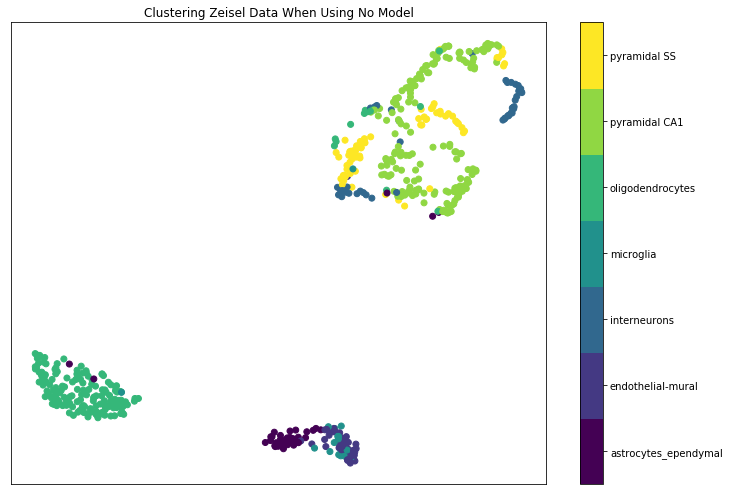

In [193]:
graph_zeisel(test_data.cpu().numpy(), test_labels, "No", zeisel_encoder)

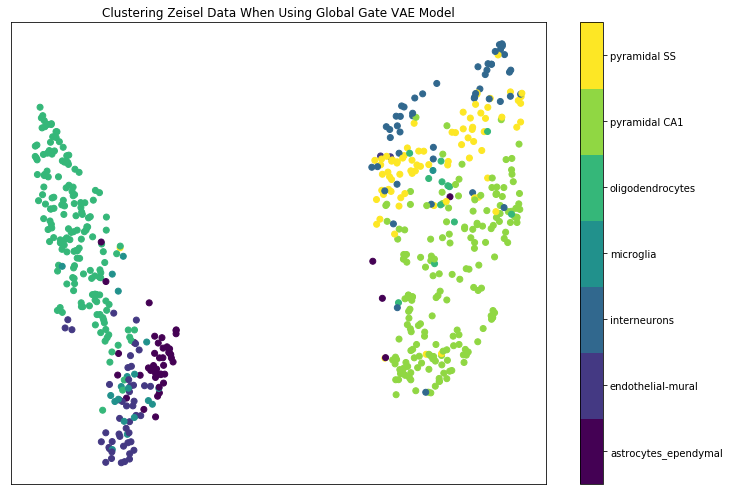

In [207]:
graph_zeisel(test_data[:, inds_global_gate].cpu().numpy(), test_labels, "Global Gate VAE", zeisel_encoder)

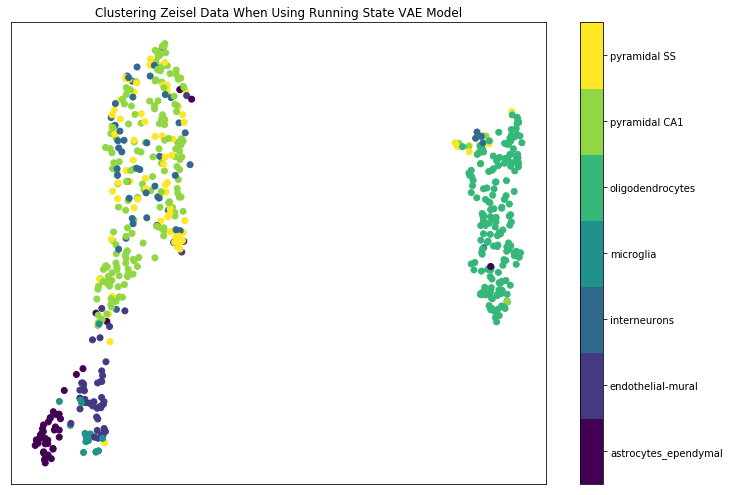

In [194]:
graph_zeisel(test_data[:, inds_running_state].cpu().numpy(), test_labels, "Running State VAE", zeisel_encoder)

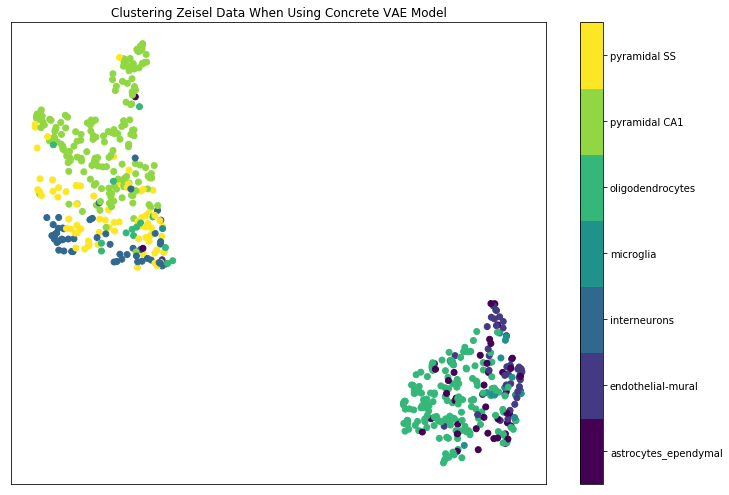

In [195]:
graph_zeisel(test_data[:, inds_concrete_vae].cpu().numpy(), test_labels, "Concrete VAE", zeisel_encoder)